In [1]:
from hlm.hierarchical.svc import SVC
import pysal as ps
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
side = np.arange(0,10,1)
grid = np.tile(side, 10)

In [3]:
beta1 = grid.reshape(10,10)
beta2 = np.fliplr(beta1).T

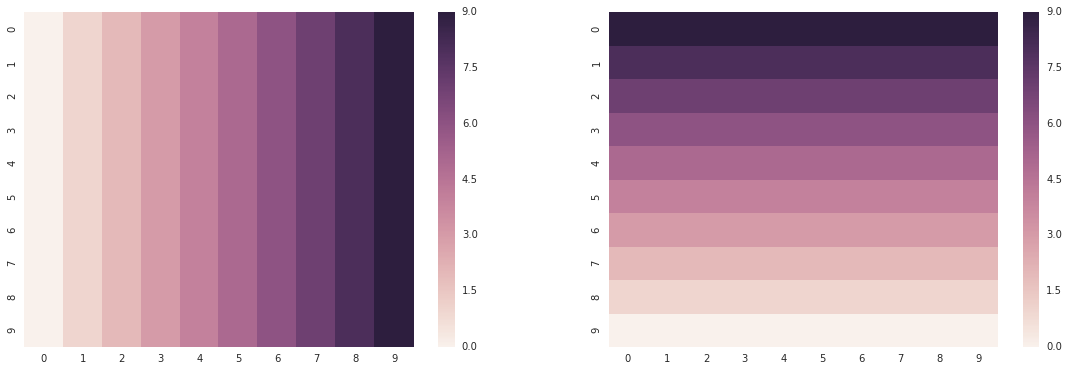

In [4]:
fig, ax = plt.subplots(1,2, figsize=(12*1.6, 6))
sns.heatmap(beta1, ax=ax[0])
sns.heatmap(beta2, ax=ax[1])
plt.show()

In [5]:
x1, x2 = np.random.normal(0,1,size=(100,2)).T

In [6]:
x1 = x1.reshape(100,1)
x2 = x2.reshape(100,1)

In [7]:
flat_beta1 = beta1.flatten().reshape(100,1)
flat_beta2 = beta2.flatten().reshape(100,1)

In [8]:
y = x1 * flat_beta1 + x2 * flat_beta2 + np.random.normal(0,1,size=(100,1))

/home/ljw/anaconda3/envs/py3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


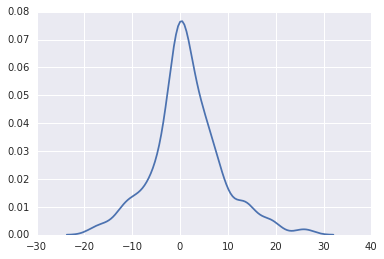

In [9]:
sns.kdeplot(y.flatten())

In [10]:
positions = np.array(list(zip(flat_beta1.flatten(), flat_beta2.flatten())))

In [11]:
X = np.hstack((x1, x2))

In [12]:
import time as t

In [13]:
m = SVC(y, X, positions, n_samples=0, 
        starting_values=dict(Phi=.5), configs=dict(jump=.2))
start = t.time()
m.sample(5000, n_jobs=4)
end = t.time() - start
print('{} seconds elapsed'.format(end))

191.67813181877136 seconds elapsed


/home/ljw/anaconda3/envs/py3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


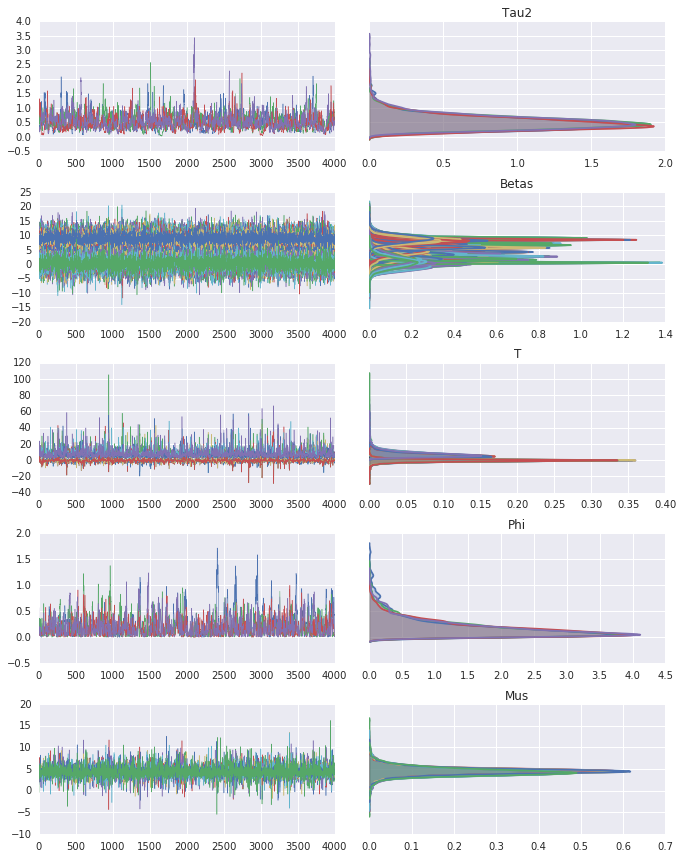

In [14]:
m.trace.plot(burn=1000)
plt.tight_layout()
plt.show()

In [28]:
a,b,c,d = np.squeeze(m.trace['Betas'])

In [29]:
est_b1s = np.squeeze(m.trace['Betas'])[:,:,::2].mean(axis=1)
est_b2s = np.squeeze(m.trace['Betas'])[:,:,1::2].mean(axis=1)

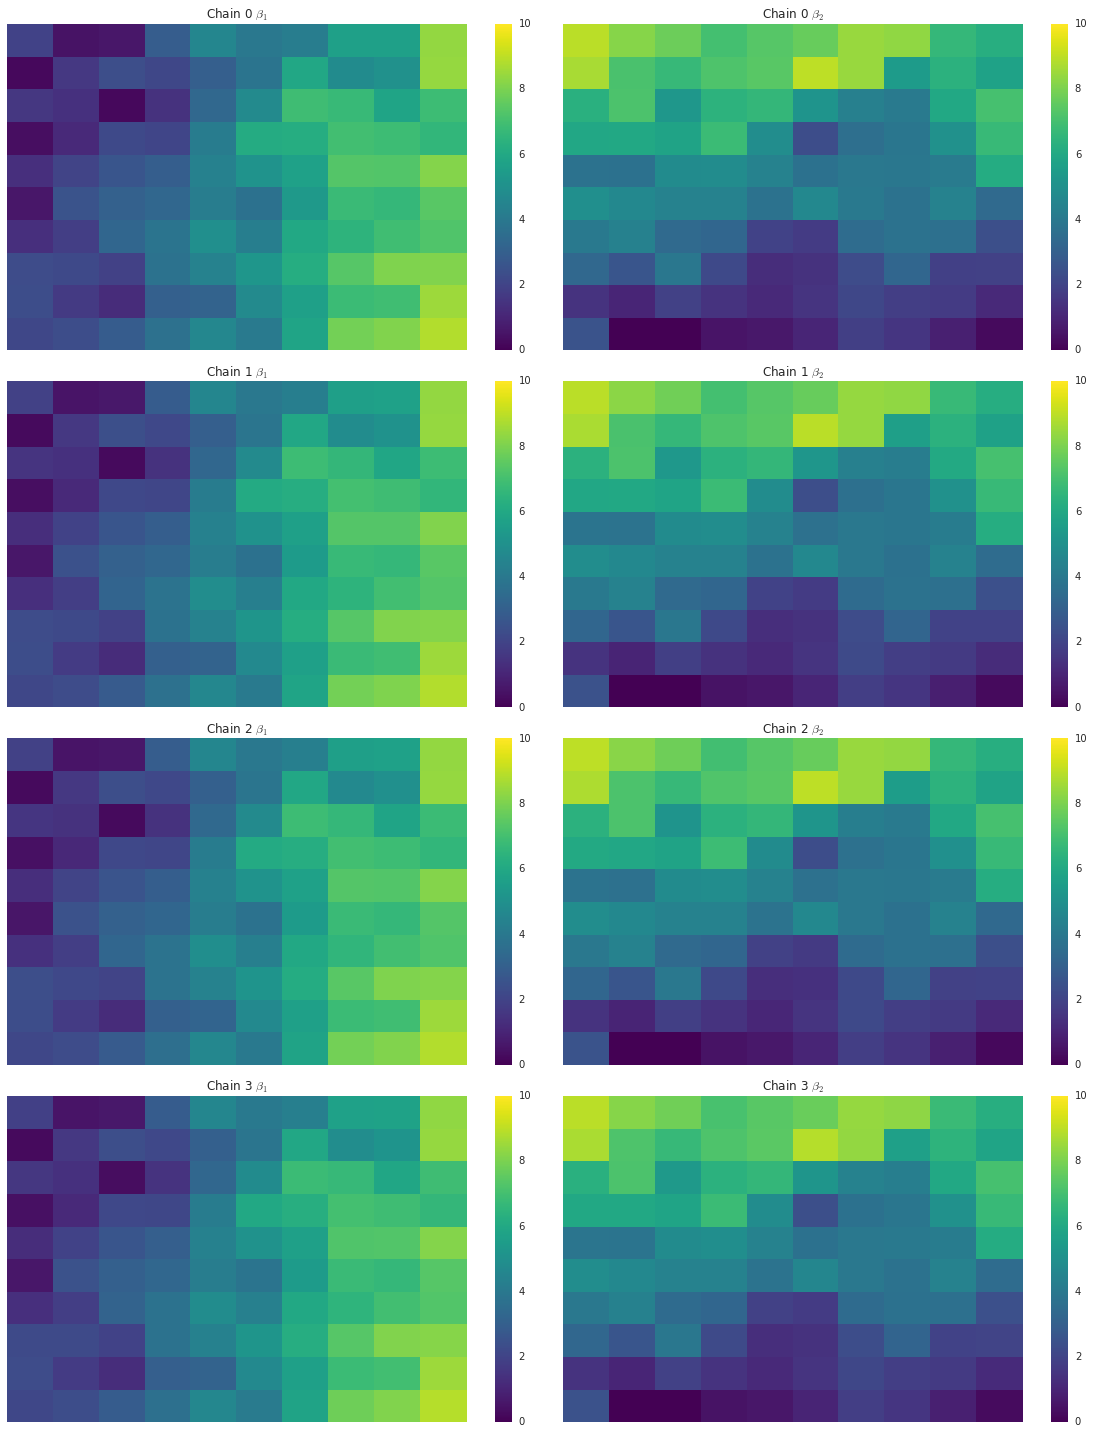

In [39]:
f,ax = plt.subplots(4,2, figsize=(16,20))
cfgs = dict(xticklabels='', yticklabels='', vmin=0, vmax=10, cmap='viridis')
for i, (b1,b2) in enumerate(zip(est_b1s, est_b2s)):
    sns.heatmap(b1.reshape(10,10),ax=ax[i,0], cbar=True, **cfgs)
    sns.heatmap(b2.reshape(10,10), ax=ax[i,1], cbar=True, **cfgs)
    ax[i,0].set_title('Chain {} $\\beta_1$'.format(i))
    ax[i,1].set_title('Chain {} $\\beta_2$'.format(i))
plt.tight_layout()
plt.show()

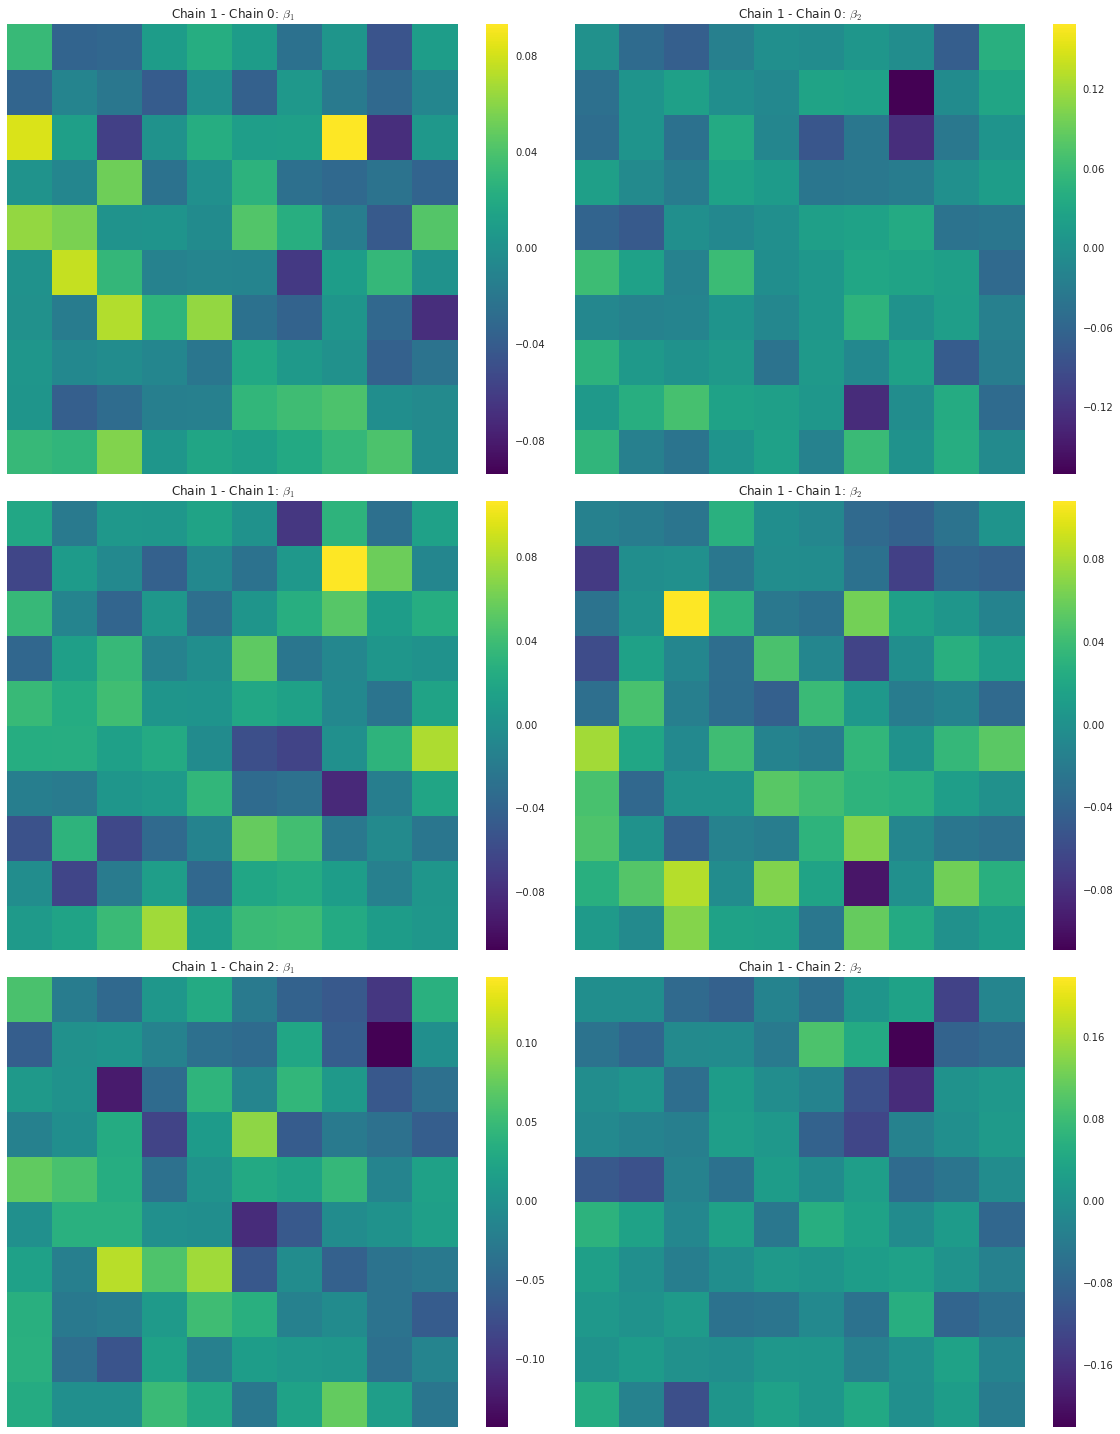

In [41]:
f,ax = plt.subplots(3,2, figsize=(16,20))
cfgs = dict(xticklabels='', yticklabels='', vmin=None, vmax=None, cmap='viridis')
b1ref = est_b1s[0].reshape(10,10)
b2ref = est_b2s[0].reshape(10,10)
for i, (b1,b2) in enumerate(zip(est_b1s[1:], est_b2s[1:])):
    sns.heatmap(b1ref - b1.reshape(10,10),ax=ax[i,0], cbar=True, **cfgs)
    sns.heatmap(b2ref - b2.reshape(10,10), ax=ax[i,1], cbar=True, **cfgs)
    ax[i,0].set_title('Chain 1 - Chain {}: $\\beta_1$'.format(i))
    ax[i,1].set_title('Chain 1 - Chain {}: $\\beta_2$'.format(i))
plt.tight_layout()
plt.show()

In [43]:
b1_resids = [beta1 - est_b1.reshape(10,10) for est_b1 in est_b1s]
b2_resids = [beta2 - est_b2.reshape(10,10) for est_b2 in est_b2s]

/home/ljw/anaconda3/envs/py3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


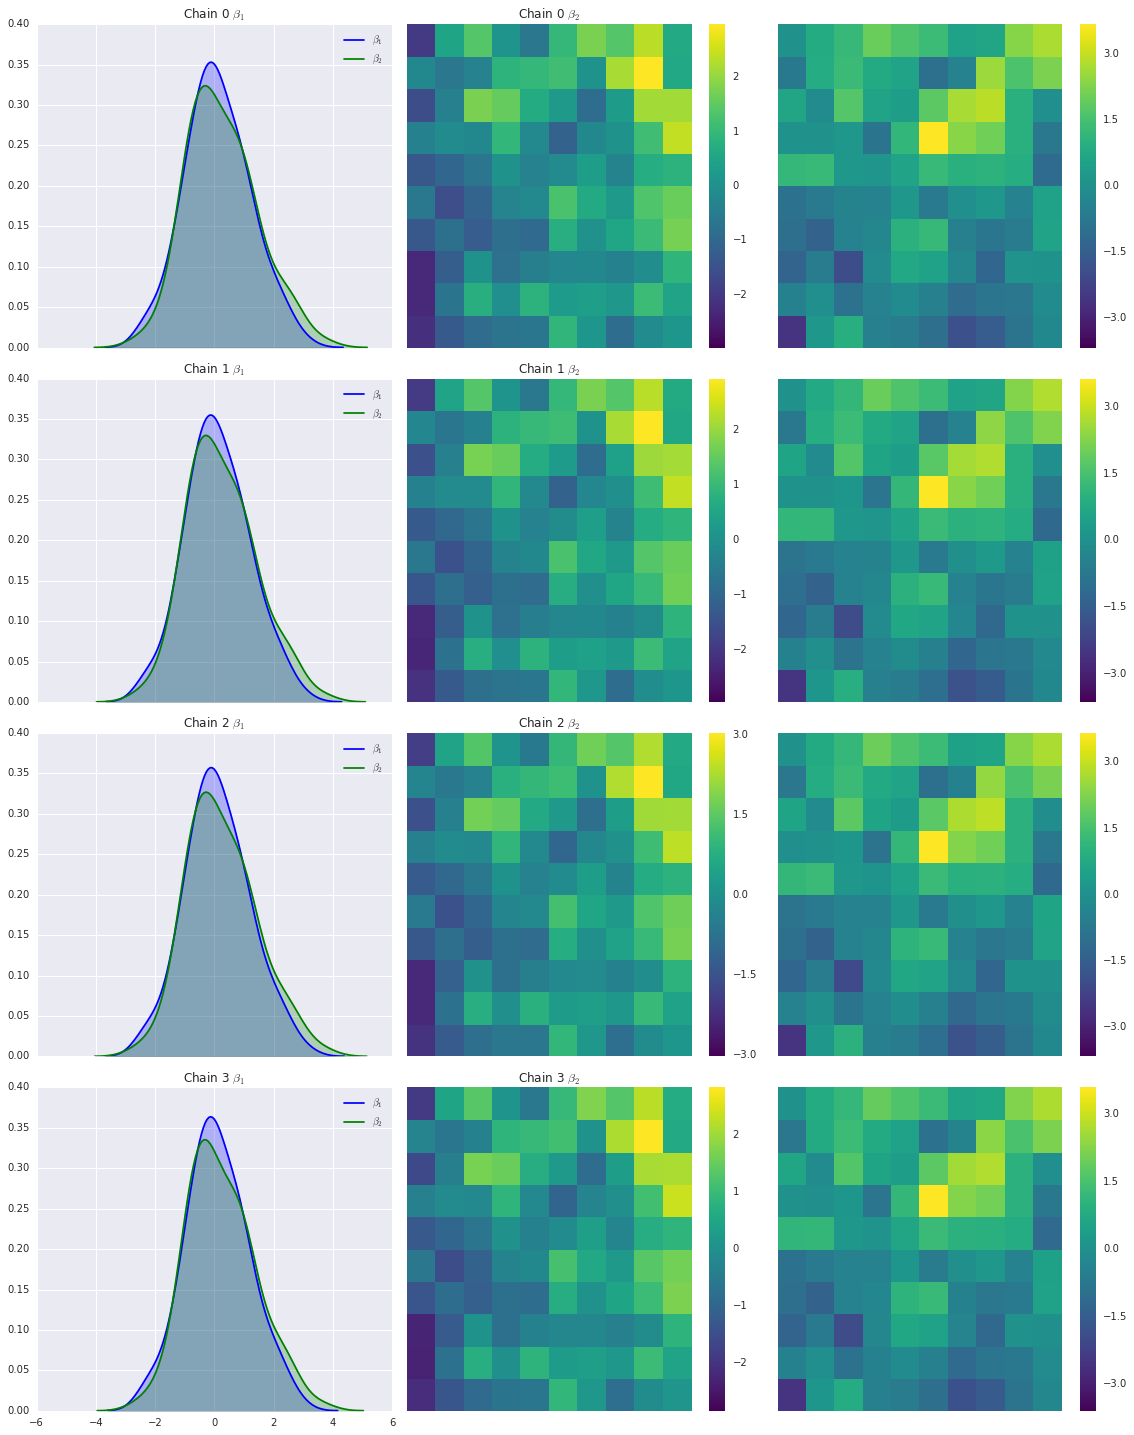

In [54]:
f,ax = plt.subplots(4,3, figsize=(16,20), sharex='col')
cfgs = dict(xticklabels='', yticklabels='', vmin=None, vmax=None, cmap='viridis')
for i, (b1r,b2r) in enumerate(zip(b1_resids, b2_resids)):
    sns.heatmap(b1r, ax=ax[i,1], cbar=True, **cfgs)
    sns.heatmap(b2r, ax=ax[i,2], cbar=True, **cfgs)
    sns.kdeplot(b1r.flatten(), ax=ax[i,0], shade=True, color='b', label=r'$\beta_1$')
    sns.kdeplot(b2r.flatten(), ax=ax[i,0], shade=True, color='g', label=r'$\beta_2$')
    ax[i,0].set_title('Chain {} $\\beta_1$'.format(i))
    ax[i,1].set_title('Chain {} $\\beta_2$'.format(i))
plt.tight_layout()
plt.show()